Utilizzo di pynetlogo per una singola simulazione.

È una pessima idea lanciare run all.

In [1]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx
import os

%matplotlib widget

### Impostazioni

In [2]:
outputdir = os.path.join('.','outputs','update2') # directory dove salvare config e output
if not os.path.exists(outputdir):
  os.makedirs(outputdir)
nl_gui = True           # false per non far partire la gui di netlogo
nl_model = "./EC2.8.nlogo" # modello da caricare in netlogo

Runnare una delle due celle seguenti in base a se vuoi cambiare variabili o caricarle da un file

In [3]:
# CARICAMENTO VARIABILI DA FILE
with open(outputdir+"/global_vars.json",'r') as f:
  global_vars = json.load(f)

print(global_vars)

{'N': 1000, 'beta': 1.0, 'mutrue': 0.0, 'vartrue': 1.0, 'update-type': 2, 'var-c': 10.0, 'var-d': 2, 'network-type': '"scale-free"', 'p': 0.01, 'pref': 1}


### Simulazione singola

#### Caricamento netlogo

In [3]:
## perché funzioni: installato tutto da conda tranne pynetlogo, installato per ultimo
## java-21-openjdk
import sys
if (sys.platform == 'linux') :
    netlogo = pynetlogo.NetLogoLink(
        gui=nl_gui,
        netlogo_home="/opt/netlogo/",
    )
else:
    netlogo = pynetlogo.NetLogoLink(
    gui=nl_gui,
)

In [4]:
netlogo.load_model(nl_model)

In [5]:
def values(var: str):
  '''
  Restituisce un array con i valori di una variabile per tutti i nodi.
  '''
  return netlogo.report(f"map [s -> [{var}] of s] sort nodes")

In [90]:
netlogo.report(f"count nodes")

1000.0

#### Avvio simulazione

In [139]:
# IMPOSTAZIONE VARIABILI GLOBALI DA PYTHON e salvataggio nel file
global_vars = {
  'N': 1000,
  'beta': 1.,
  'mutrue': 0.,
  'vartrue': 1.,
  'update-type': 2,
  'var-c': 10.,
  #'var-d': 2,
  'network-type': "\"scale-free\"", #random o scale-free
  'p': 0.01, # random network, probabilità di accendere link
  'pref': 1, #pref=1 ricrea link solo con nodi affini
  'initial-sampling': "\"bivariate\"",
  'dist': 0.
}

# with open(os.path.join(outputdir,"global_vars.json"),'w') as f:
#   f.write(json.dumps(global_vars,indent=2))

In [140]:
# IMPOSTAZIONE VARIABILI GLOBALI E SETUP IN NETLOGO
netlogo.command('clear-all')
for name in global_vars:
  netlogo.command(f'set {name} {global_vars[name]}')

netlogo.command('setup')

In [141]:
iters = 100
mus = []
sigma2s = []
nets = []
lones = []
rewired =[]
mus.append(values('mu0'))
sigma2s.append(values('var0'))
nets.append(netlogo.report("[list ([label] of end1) ([label] of end2)] of edges").astype(int))

In [142]:
for n in range(1,iters+1):
  netlogo.command('go')
  mus.append(values('mu'))
  sigma2s.append(values('var'))
  lones.append(netlogo.report('lonely'))
  rewired.append(netlogo.report('rewired'))
  if (n%10)==0:
    nets.append(netlogo.report("[list ([label] of end1) ([label] of end2)] of edges").astype(int))
  print(f"\r{n}/{iters}",end="",flush=True)
print()

100/100


In [94]:
#se non ci sono link ripetuti, questi due (e tutti quelli in mezzo) devono avere la stessa shape
np.unique(nets[0],axis=0), np.unique(nets[-1],axis=0)

(array([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [999, 741],
        [999, 810],
        [999, 951]], shape=(9945, 2)),
 array([[  0,   2],
        [  0,   4],
        [  0,  73],
        ...,
        [999, 640],
        [999, 757],
        [999, 810]], shape=(9945, 2)))

In [45]:
np.unique(np.array([[1,2],[2,1],[1,2]]),axis=0)

array([[1, 2],
       [2, 1]])

#### Salvataggio

In [49]:
import datetime
datestr = datetime.datetime.now().strftime("%m_%d_%H_%M")
outputsubdir=os.path.join(outputdir,
                     f'beta={global_vars['beta']:.1f}_varc={global_vars['var-c']:.1f}',
                     datestr)
print(outputsubdir)

./outputs/update2/beta=1.0_varc=10.0/07_13_12_06


In [14]:
os.makedirs(outputsubdir)
np.save(os.path.join(outputsubdir,'mus.npy'),
        mus)
np.save(os.path.join(outputsubdir,"sigma2s.npy"),
        sigma2s)
np.save(os.path.join(outputsubdir,"nets.npy"),
        nets)

#### Qualche plot dei risultati

In [143]:
meanmu = np.array([np.mean(mu) for mu in mus])
meansigma = np.sqrt(np.array([np.mean(var) for var in sigma2s]) )

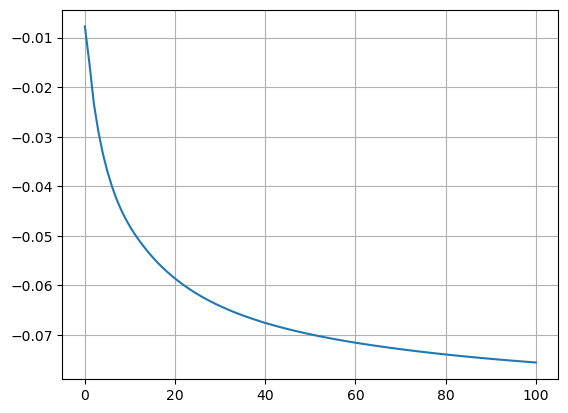

In [144]:
plt.close('all')
plt.plot(meanmu)
plt.grid()

In [145]:
muarr = np.array(mus)
muarr.shape

(101, 1000)

In [37]:
%matplotlib inline

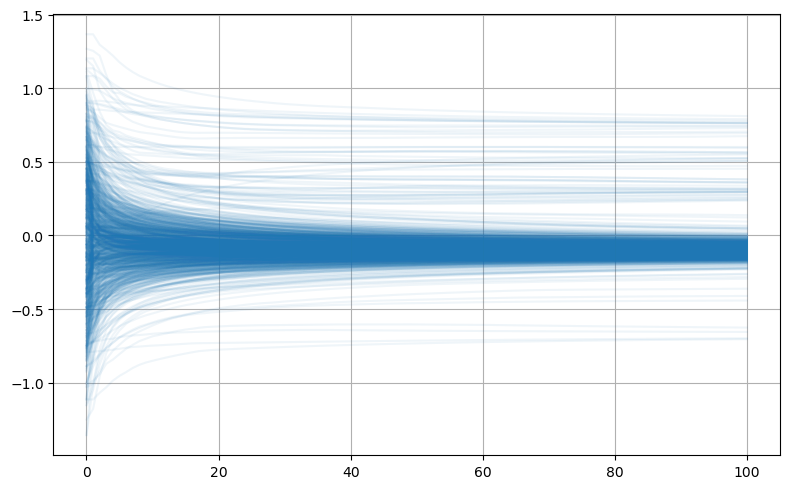

In [146]:
plt.close('all')
fig, ax = plt.subplots(figsize = (8,5), layout='tight')
for i in range(1000):
  #ax.plot(mus[i],alpha=0.05,color='C0')
  ax.plot(np.array(mus)[:,i],alpha=0.07, color='C0')

#ax.plot( np.array(mus)[:,0] )

ax.grid()

In [147]:
mu = mus[-1]#values('mu')
sigmas = np.sqrt(sigma2s[-1])#np.sqrt(values('var'))

In [148]:
# vettore del numero di nodi concordi, per ciascun nodo
friends = [np.sum([(abs(m - mu[i])< global_vars['beta']* sigmas[i]) for m in (mu)]) for i in range(1000)]

In [149]:
np.min(friends), np.max(friends),lones[-1]

(np.int64(3), np.int64(996), 49.0)

In [150]:
bff = np.argmax(friends) # nodo con più amici tra tutti
wff = np.argmin(friends) 
bff,wff

(np.int64(10), np.int64(183))

In [151]:
netlogo.report(f'[mu] of node {bff}'),netlogo.report(f'[var] of node {bff}')

(0.6018541157363062, 1.5050807458232125)

In [152]:
netlogo.report(f'[mu] of node {wff}'),netlogo.report(f'[var] of node {wff}')

(-0.4424070259841215, 0.016814988175408684)

In [89]:
for net in nets:
  print(np.unique(net,axis=0).shape,net.shape)

(1997, 2) (1997, 2)
(1997, 2) (1997, 2)
(1997, 2) (1997, 2)
(1997, 2) (1997, 2)
(1997, 2) (1997, 2)
(1997, 2) (1997, 2)
(1997, 2) (1997, 2)
(1997, 2) (1997, 2)
(1997, 2) (1997, 2)
(1997, 2) (1997, 2)
(1997, 2) (1997, 2)


Text(0.5, 1.0, 'Distribuzione numero di nodi concordi per ciascun nodo')

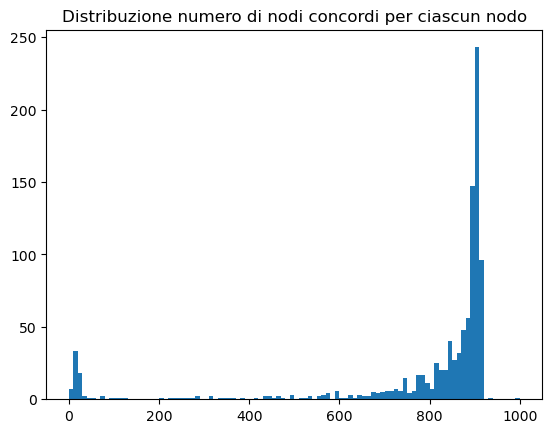

In [153]:
plt.close('all')
plt.hist(friends,bins=100,range=(0,1000))
plt.title('Distribuzione numero di nodi concordi per ciascun nodo')

In [154]:
netlogo.report('[tc] of edges').sum()

np.float64(50.0)

In [38]:
lones[-1],netlogo.report('pref')

(4.0, 1.0)

In [155]:
[len(np.unique(net,axis=0)) for net in nets]

[9945, 9945, 9945, 9945, 9945, 9945, 9945, 9945, 9945, 9945, 9945]

#### Network

In [156]:
G0  = nx.from_edgelist(nets[0].tolist(),create_using=nx.DiGraph)
for i in sorted(G0.nodes):
  (G0.nodes)[i]['mu'] = mus[0][i]
  (G0.nodes)[i]['sigma2']= sigma2s[0][i]
GF = nx.from_edgelist(nets[-1].tolist(),create_using=nx.DiGraph)
for i in sorted(GF.nodes):
  (GF.nodes)[i]['mu'] = mus[-1][i]
  (GF.nodes)[i]['sigma2']= sigma2s[-1][i]

In [157]:
GF.out_edges(0) # qualsiasi nodo ha lo stesso numero di edge uscenti per costruzione

OutEdgeDataView([(0, 5), (0, 429), (0, 210), (0, 939), (0, 899), (0, 326), (0, 6), (0, 1), (0, 998), (0, 2)])

In [158]:
len(GF.edges)

9945

In [159]:
toremove = []
for edge in GF.edges:
  if abs(GF.nodes[edge[0]]['mu']-GF.nodes[edge[1]]['mu'])>=global_vars['beta']*np.sqrt(GF.nodes[edge[0]]['sigma2']):
    toremove.append(edge)

for edge in toremove:
  GF.remove_edge(*edge)

In [160]:
len(GF.edges)

9896

In [161]:
toremove = []
for edge in G0.edges:
  if abs(G0.nodes[edge[0]]['mu']-G0.nodes[edge[1]]['mu'])>=global_vars['beta']*np.sqrt(G0.nodes[edge[0]]['sigma2']):
    toremove.append(edge)

for edge in toremove:
  G0.remove_edge(*edge)

In [162]:
sorted([len(i) for i in nx.strongly_connected_components(G0)],reverse=True)[:10],sorted([len(i) for i in nx.strongly_connected_components(GF)],reverse=True)[:]

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [933, 46, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [163]:
sorted([len(i) for i in nx.weakly_connected_components(GF)])[::-1]

[996, 4]

In [164]:
netlogo.report('count edges')

9945.0

In [75]:
len(GF.edges),len(G0.edges)

(1997, 1997)

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_63452/2413231548.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu$')


Text(0.5, 0, '$\\mu$')

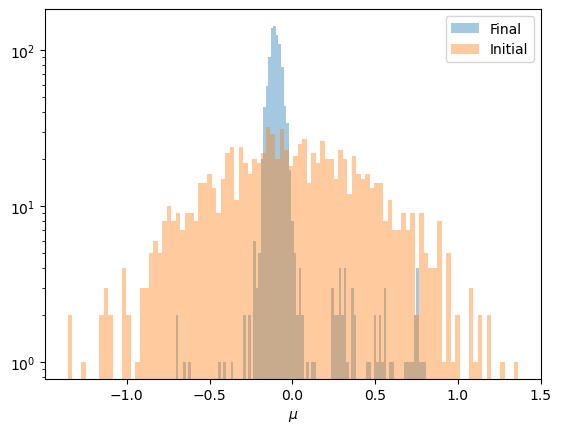

: 

In [ ]:
plt.close('all')
plt.hist(mus[-1],bins=100,alpha=0.4,label='Final')
plt.hist(mus[0],bins=100,alpha=0.4,label='Initial')
plt.legend()
plt.yscale('log')
plt.xlabel('$\mu$')


In [32]:
np.min(mus[-1])

np.float64(-0.4755753419796451)

#### Salvataggio medie, varianze e grafo
metto una stringa con data e ora prima per identificare le simulazioni; la cartella definita sopra identifica il setup.

`*outputdir*/MESE_GIORNO_ORE_MINUTI_mus.npy`

si riaprono con `np.load(*path*)`

Per salvare il grafo, la roba più easy mi sembra salvare la edgelist in un file csv; ogni riga è un link, tipo:
```
0,1
1,0
0,2
2,0
```
eccetra; si può caricare in networkx con `graph = nx.read_edgelist(*filepath*, delimiter=',',nodetype=int)`.

In [ ]:
## both-ends non tiene conto della direzione del link!!!
netlogo.command( f"csv:to-file \"{outputdir}{datestr}_edgelist.csv\" [ [ (who) ] of both-ends ] of links" )

NameError: name 'datestr' is not defined

In [169]:
netlogo.report('[label] of node 100')

100.0

Per averla in python direttamente:

In [177]:
edgelist=netlogo.report("[list ([label] of end1) ([label] of end2)] of edges")

In [178]:
np.unique(edgelist,axis=0)

array([[  0.,   1.],
       [  0.,   2.],
       [  1.,   2.],
       ...,
       [998., 535.],
       [999.,  22.],
       [999., 501.]], shape=(1997, 2))

In [ ]:
import networkx as nx

In [24]:
G  = nx.from_edgelist(edgelist.tolist(),create_using=nx.DiGraph)

In [28]:
G.in_edges(1)

InEdgeDataView([(572, 1), (190, 1), (40, 1), (443, 1), (76, 1), (539, 1), (859, 1), (876, 1), (13, 1), (446, 1), (502, 1), (923, 1), (197, 1), (912, 1), (302, 1), (506, 1), (702, 1), (872, 1), (42, 1), (783, 1), (90, 1)])

In [25]:
sorted([len(i) for i in nx.strongly_connected_components(G)],reverse=True)

[596,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1

In [ ]:
netlogo.kill_workspace()

### Simulazioni multiple

In [ ]:
num_sim = 10 #numero di simulazioni da effettuare
iters = 100  #iterazioni per ogni simulazione

muzeros = [] # liste che conterranno tutte le mu di tutte le simulazioni
sigma2zeros = []
mufinals = []
sigma2finals = []
edgelists = []

In [ ]:
import sys
if (sys.platform == 'linux') :
    netlogo = pynetlogo.NetLogoLink(
        gui=nl_gui,
        netlogo_home="/opt/netlogo/",
    )
else:
    netlogo = pynetlogo.NetLogoLink(
    gui=nl_gui,
)

netlogo.load_model(nl_model)

NetLogo Startup Error
org.picocontainer.PicoCompositionException: Duplicate Keys not allowed. Duplicate for 'class org.nlogo.compile.Compiler'
	at org.picocontainer.DefaultPicoContainer.addAdapterInternal(DefaultPicoContainer.java:438)
	at org.picocontainer.DefaultPicoContainer.addComponent(DefaultPicoContainer.java:548)
	at org.picocontainer.DefaultPicoContainer.addComponent(DefaultPicoContainer.java:501)
	at org.picocontainer.DefaultPicoContainer.addComponent(DefaultPicoContainer.java:488)
	at org.nlogo.util.Pico.add(Pico.scala:11)
	at org.nlogo.app.App$.mainWithAppHandler(App.scala:86)
	at org.nlogo.app.App$.main(App.scala:68)
	at org.nlogo.app.App.main(App.scala)
	at netLogoLink.NetLogoLink.<init>(NetLogoLink.java:44)


: 

In [53]:
def values(var: str):
  '''
  Restituisce un array con i valori di una variabile per tutti i nodi.
  '''
  return netlogo.report(f"map [s -> [{var}] of s] sort nodes")

In [ ]:
for sim in range(num_sim):
  netlogo.command('clear-all')
  for name in global_vars:
    netlogo.command(f'set {name} {global_vars[name]}')

  netlogo.command('setup')

  muzeros.append(values('mu0'))
  sigma2zeros.append(values('var0'))
  edgelists.append(netlogo.report("[list ([label] of end1) ([label] of end2)] of edges").astype(int) )

  for n in range(1,iters+1):
    netlogo.command('go')
    #mus.append(values('mu'))
    #sigma2s.append(values('var'))
    print(f"\rSimulazione {sim}, timestep {n}/{iters}",end="",flush=True)
  print()
  mufinals.append(values('mu'))
  sigma2finals.append(values('var'))

Simulazione 0, timestep 100/100
Simulazione 1, timestep 100/100
Simulazione 2, timestep 100/100
Simulazione 3, timestep 100/100
Simulazione 4, timestep 100/100
Simulazione 5, timestep 100/100
Simulazione 6, timestep 100/100
Simulazione 7, timestep 100/100
Simulazione 8, timestep 100/100
Simulazione 9, timestep 100/100


In [76]:
netlogo.kill_workspace()

In [83]:
amus = np.array(mufinals)
asigma2s = np.array(sigma2finals)

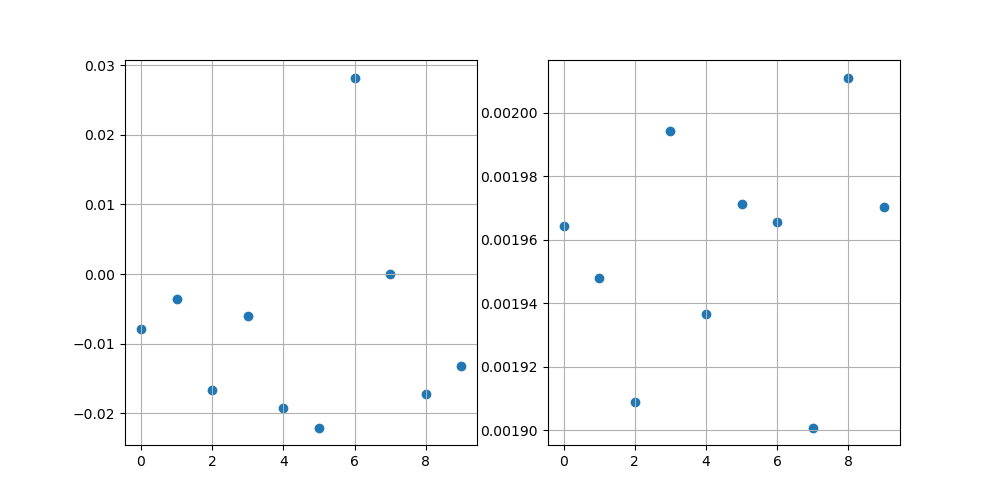

In [87]:
fig, ax = plt.subplots(ncols=2, figsize =(10,5))
ax[0].scatter(np.arange(10),np.mean(amus,axis=1))
ax[1].scatter(np.arange(10),np.mean(asigma2s,axis=1))


for a in ax:
  a.grid()

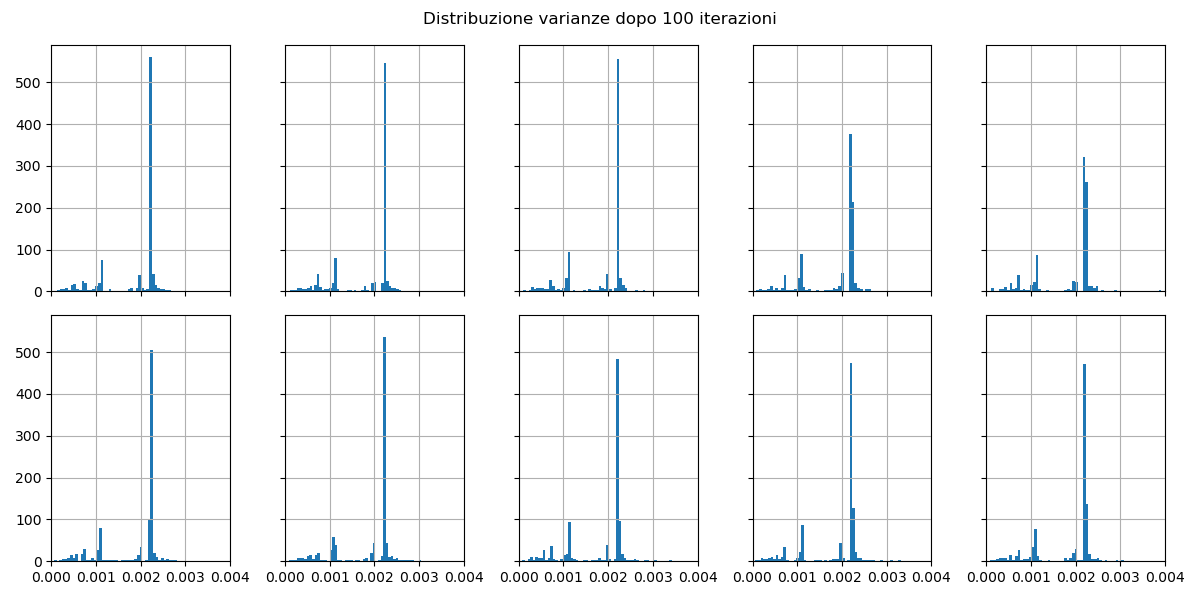

In [115]:
fig1,ax1 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all', sharex='all',layout='tight')
fig1.suptitle('Distribuzione varianze dopo 100 iterazioni')
for i,a in enumerate(ax1.flatten()):
  a.hist(asigma2s[i],bins=300)
  a.set_xlim((0,0.004))
  a.grid()

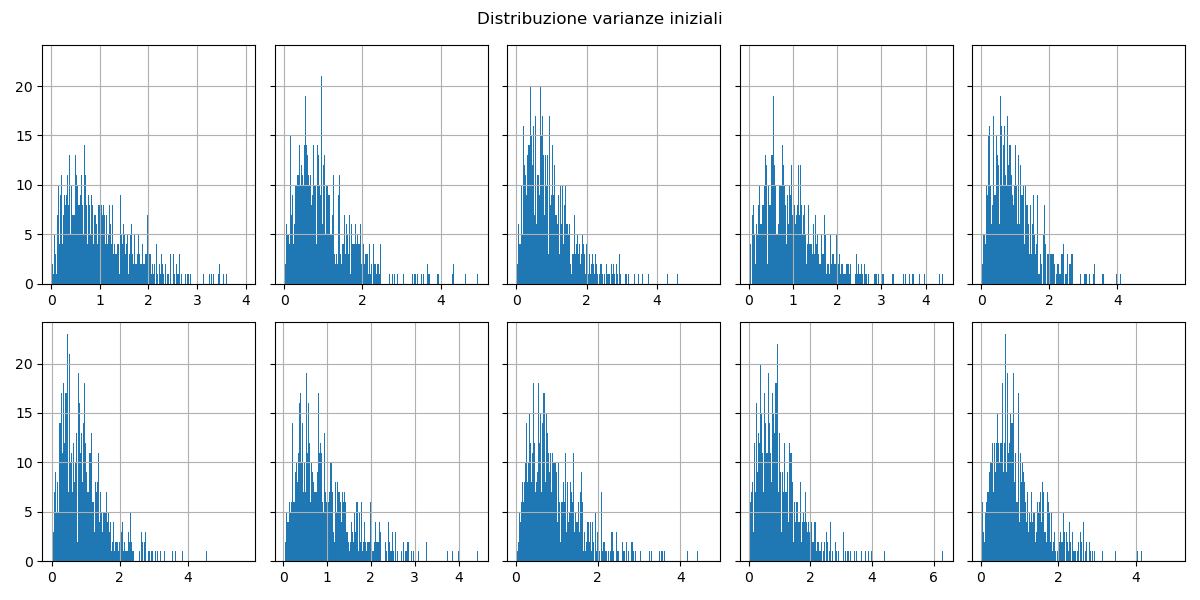

In [116]:
fig2,ax2 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all',layout='tight')
fig2.suptitle('Distribuzione varianze iniziali')
for i,a in enumerate(ax2.flatten()):
  a.hist(sigma2zeros[i],bins=300)
  #a.set_xlim((0,0.004))
  a.grid()

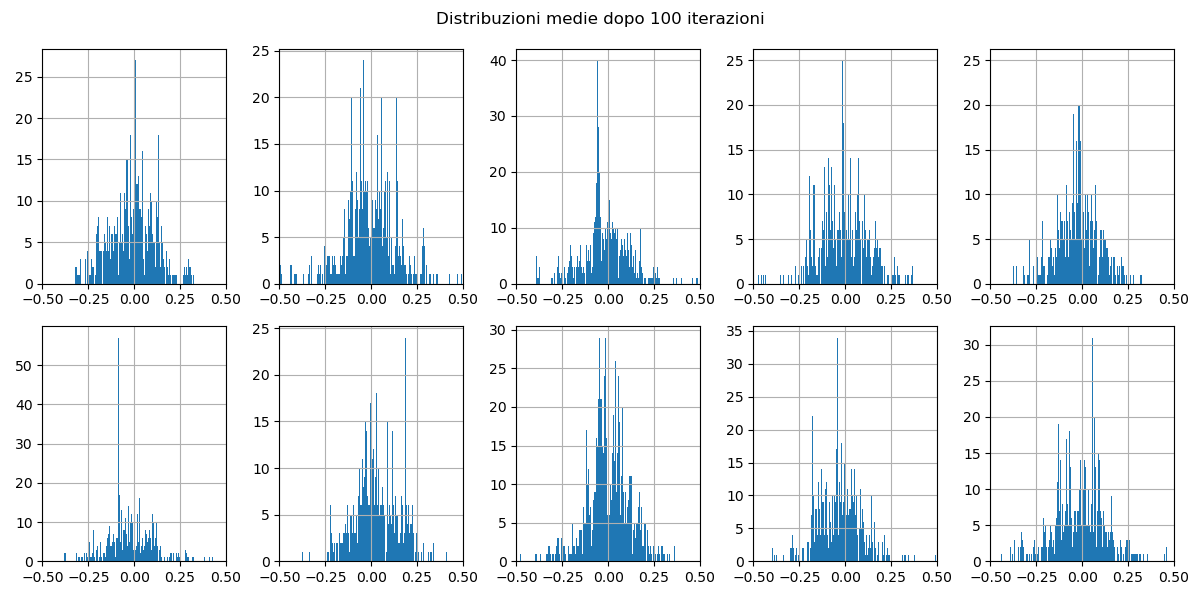

In [118]:
fig3,ax3 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='none',layout='tight')
fig3.suptitle("Distribuzioni medie dopo 100 iterazioni")
for i,a in enumerate(ax3.flatten()):
  a.hist(amus[i],bins=300)
  a.set_xlim((-0.50,0.5))
  a.grid()

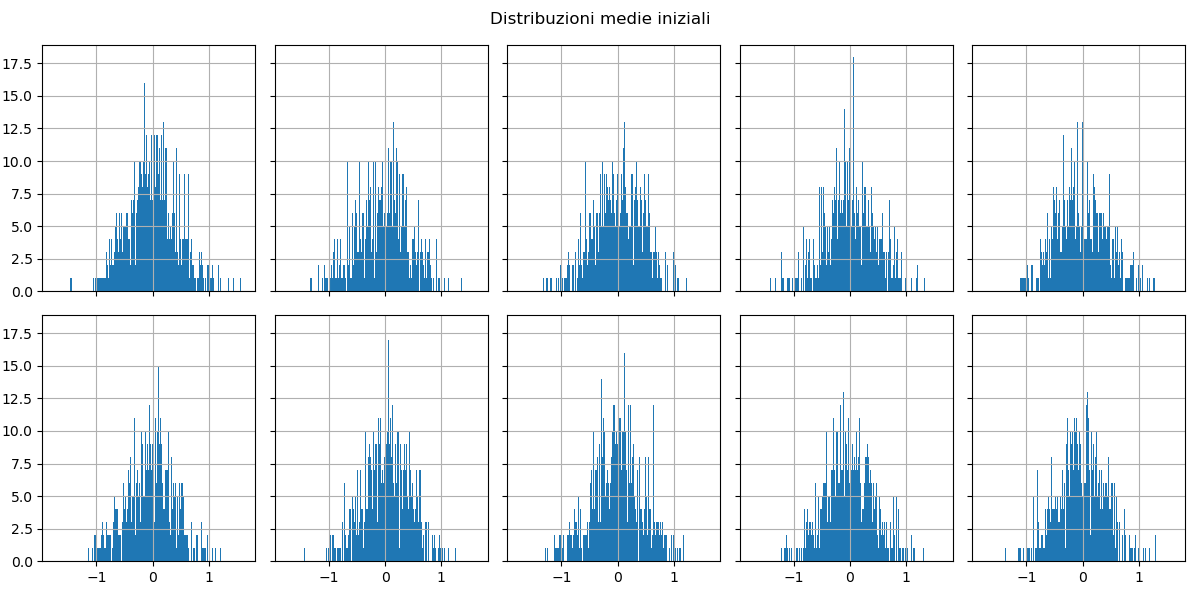

In [119]:
fig4,ax4 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all',sharex='all',layout='tight')
fig4.suptitle("Distribuzioni medie iniziali")
for i,a in enumerate(ax4.flatten()):
  a.hist(muzeros[i],bins=300)
  #a.set_xlim((-0.50,0.5))
  a.grid()

In [120]:
fig1.savefig(outputdir+'finalsigmas.png')
fig2.savefig(outputdir+'initialsigmas.png')
fig3.savefig(outputdir+'finalmus.png')
fig4.savefig(outputdir+'initialmus.png')


In [121]:
plt.close('all')

In [137]:
datestr = (datetime.datetime.now()).strftime("%m_%d_%H_%M_")
np.save(outputdir+datestr+"10mus.npy", np.stack([np.array(muzeros),amus]) )
np.save(outputdir+datestr+"10sigma2s.npy", np.stack([np.array(sigma2zeros),asigma2s]))